In [37]:
from residual_learning.utils import (
                BaseForecaster, 
                ResidualForecasterDarts,
                TimeSeriesPreprocessor,
)
import pandas as pd
import matplotlib.pyplot as plt
import os
from darts import TimeSeries
from darts.metrics import smape
import numpy as np
import time

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
targets = pd.read_csv("targets.csv.gz")

In [164]:
targets.head()

,datetime,site_id,chla,oxygen,temperature,air_tmp
0,2016-03-05,ARIK,NaN,NaN,NaN,NaN
1,2016-03-06,ARIK,NaN,NaN,NaN,NaN
2,2016-03-07,ARIK,NaN,NaN,NaN,NaN
3,2016-03-08,ARIK,NaN,NaN,NaN,NaN
4,2016-03-09,ARIK,NaN,NaN,NaN,NaN


In [146]:
targets["site_id"].unique()

array(['ARIK', 'BARC', 'BIGC', 'BLDE', 'BLUE', 'BLWA', 'CARI', 'COMO',
       'CRAM', 'CUPE', 'FLNT', 'GUIL', 'HOPB', 'KING', 'LECO', 'LEWI',
       'LIRO', 'MART', 'MAYF', 'MCDI', 'MCRA', 'OKSR', 'POSE', 'PRIN',
       'PRLA', 'PRPO', 'REDB', 'SUGG', 'SYCA', 'TECR', 'TOMB', 'TOOK',
       'WALK', 'WLOU'], dtype=object)

Below cell will preprocess data for all the sites whereby gaps in data are filled. This performs GP fits which are time intensive, so this will take a while to execute. One could parallelize with Ray, but decided to do it serially as I am working slowly on other things. Takes around 6 hours to complete.

In [145]:
data_preprocessor = TimeSeriesPreprocessor()
start = time.time()
for site in targets["site_id"].unique():
    data_preprocessor.preprocess_data(site)
print(time.time() - start)

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consi

19986.0654194355


Plotting all the processed TimeSeries, note that in utils I have added a method to do this.

In [155]:
# Should've added this to the data preprocessor class ripp
def plot_by_site(preprocessor, site):
    for key in preprocessor.sites_dict[site].keys():
        plt.clf()
        preprocessor.sites_dict[site][key].plot(color="blue", label=f"{key} @ {site}")
        plt.show()

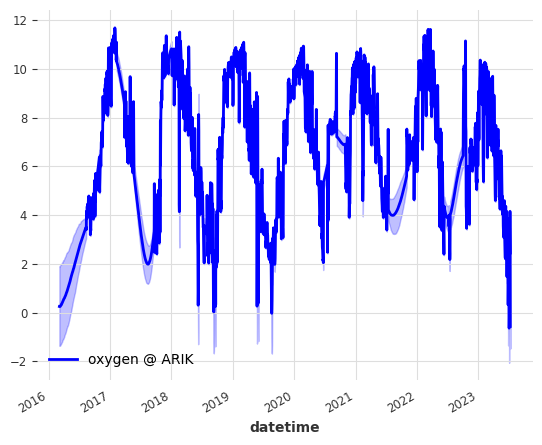

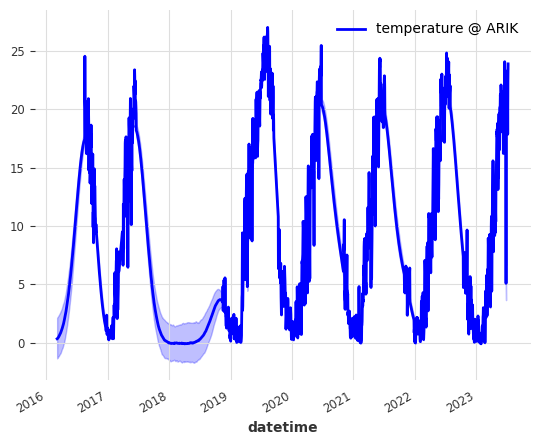

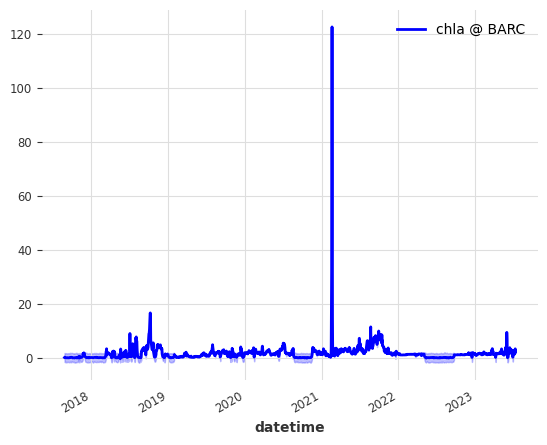

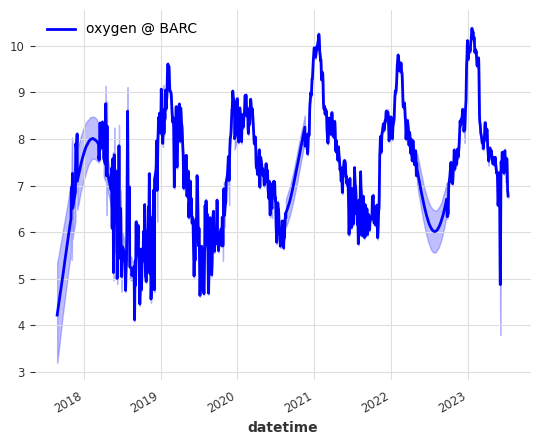

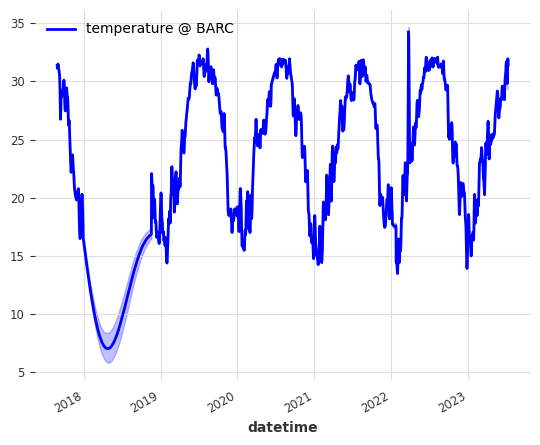

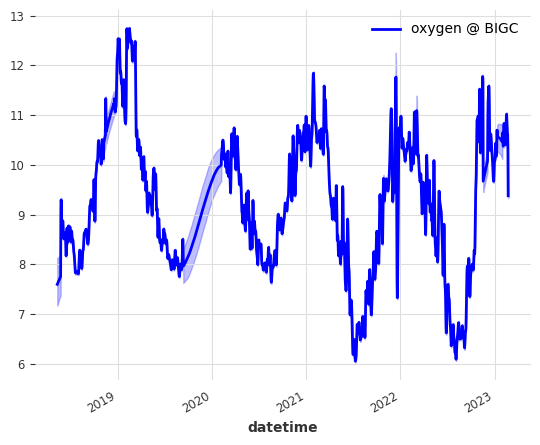

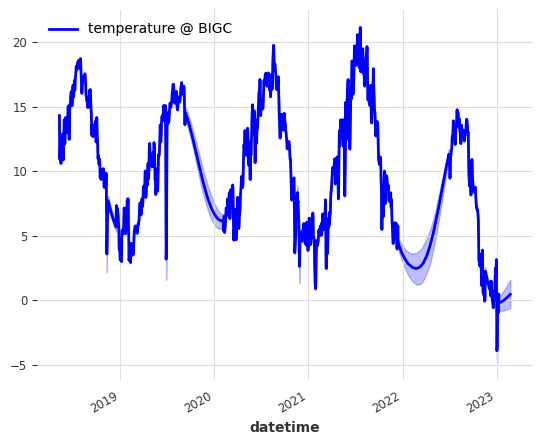

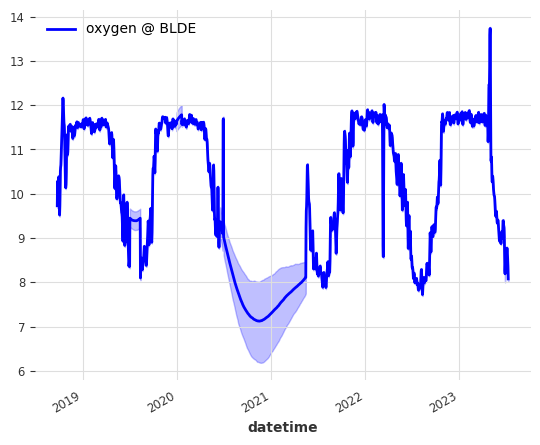

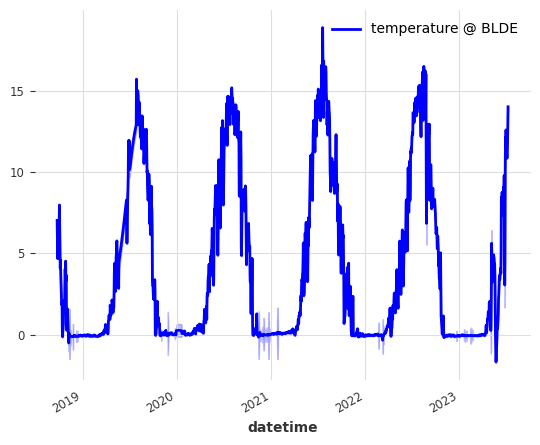

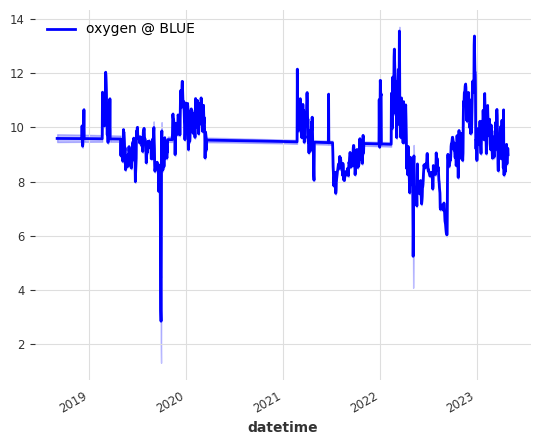

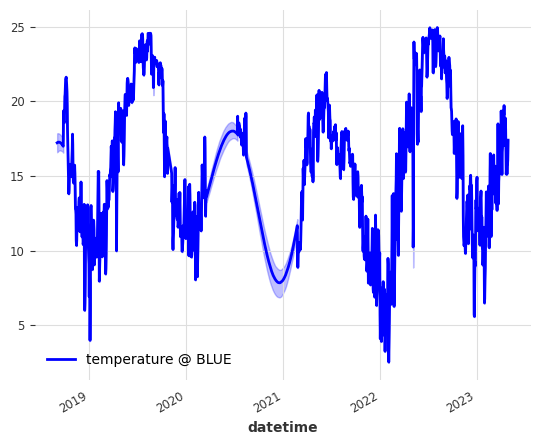

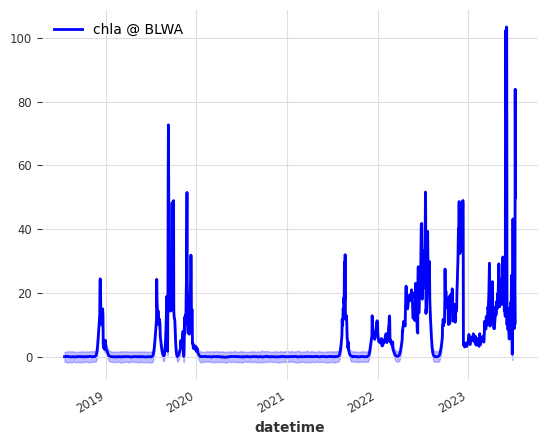

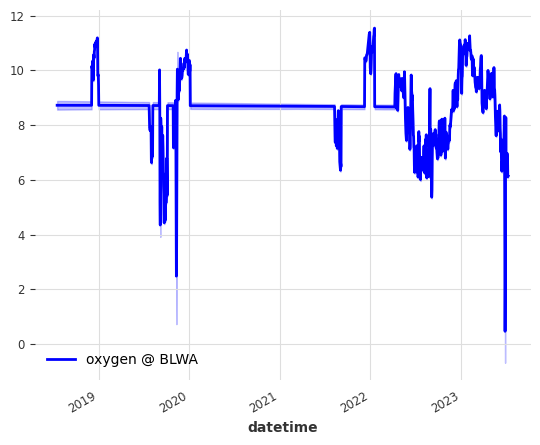

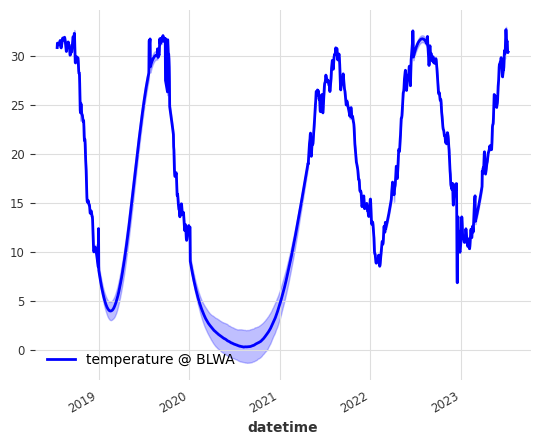

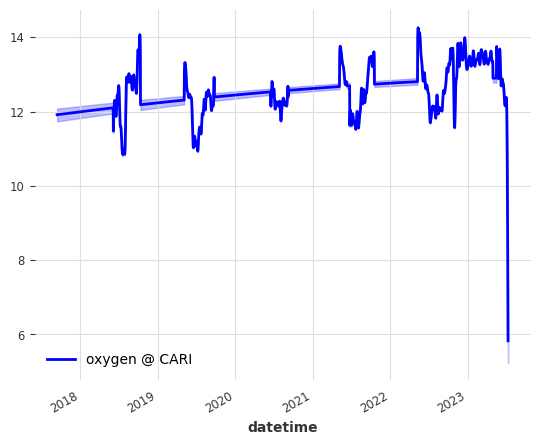

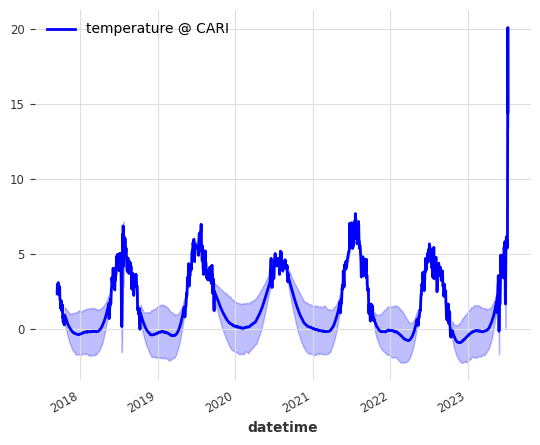

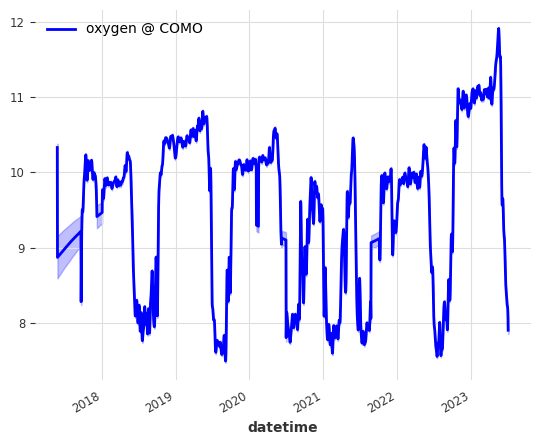

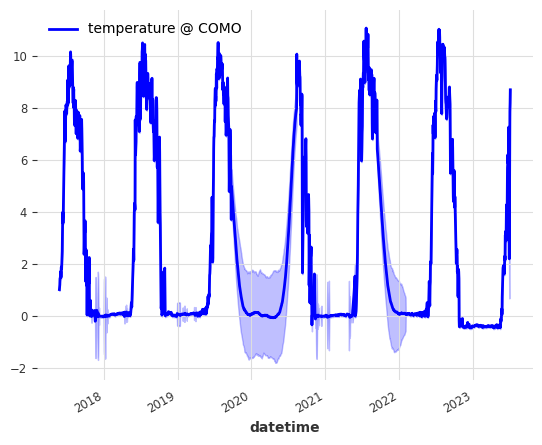

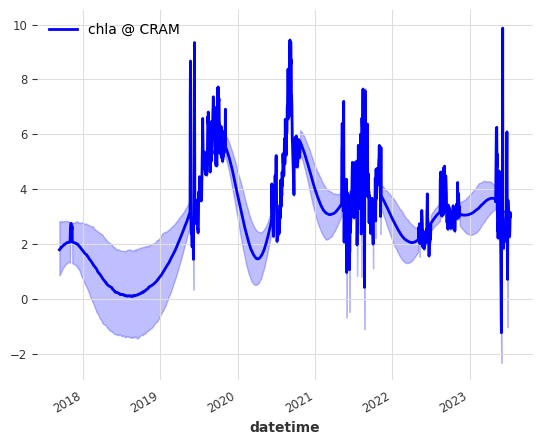

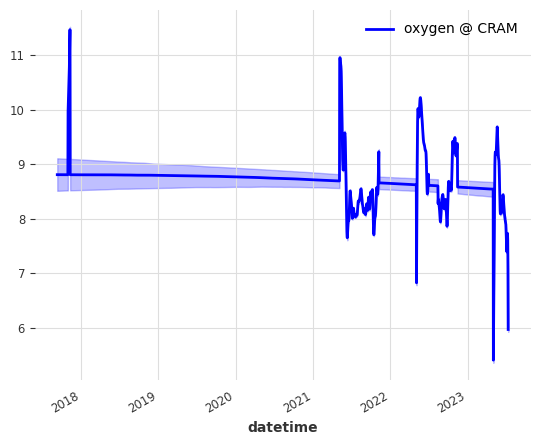

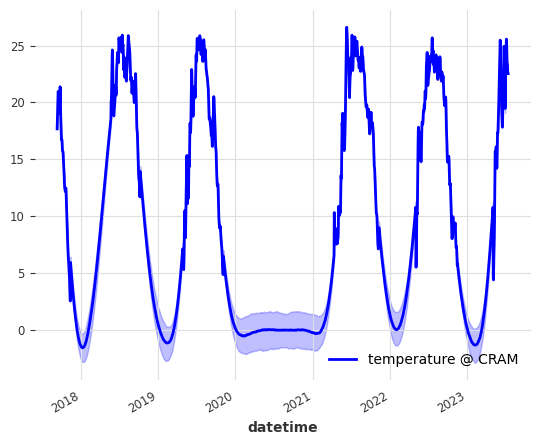

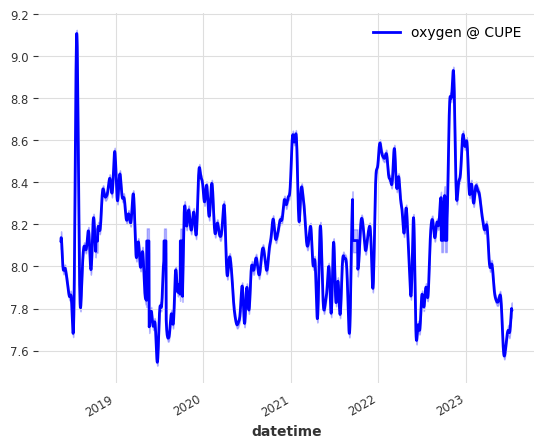

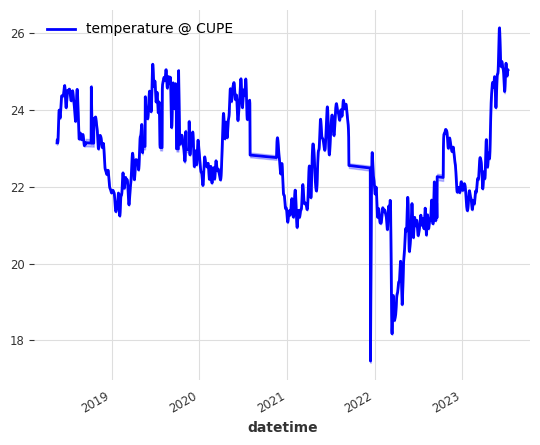

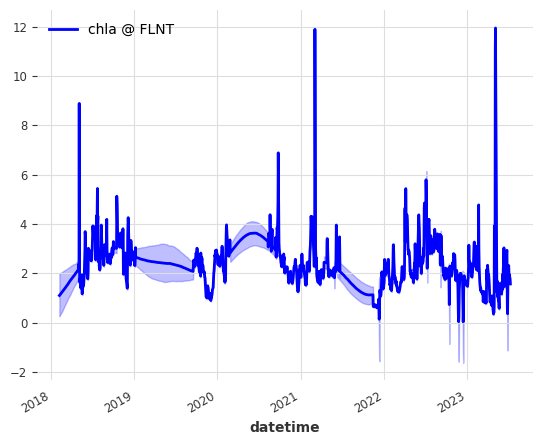

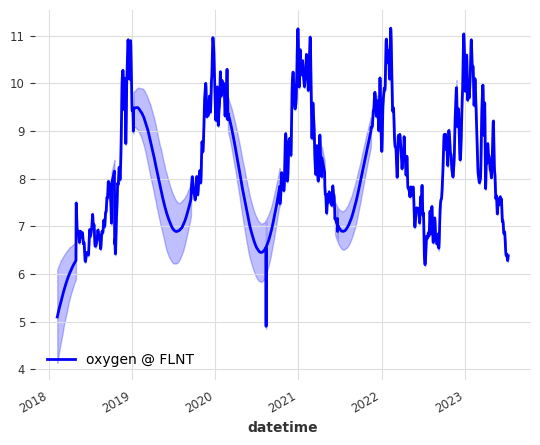

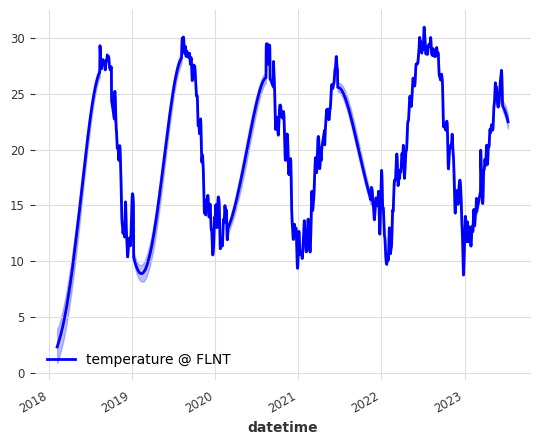

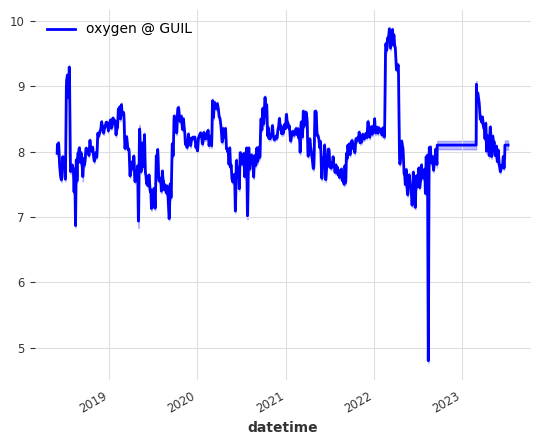

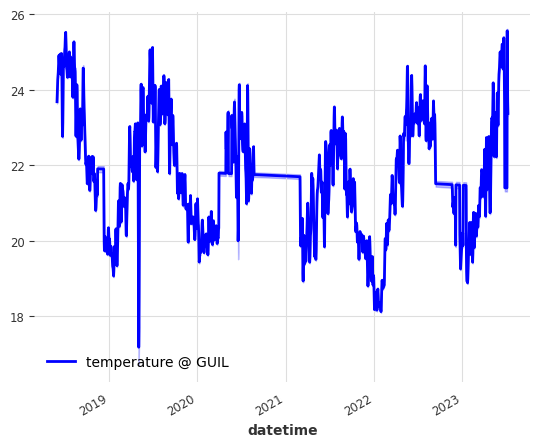

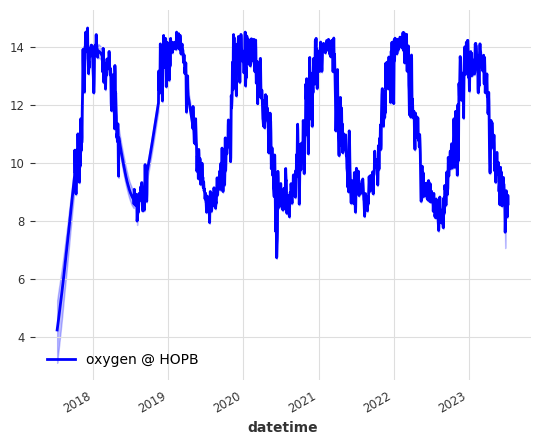

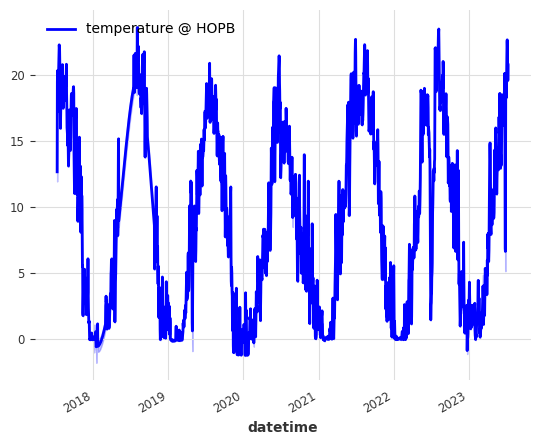

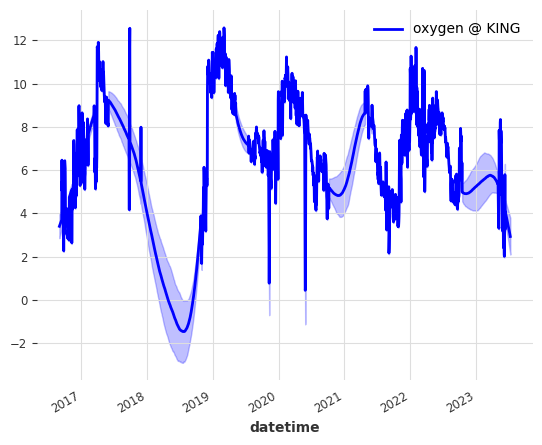

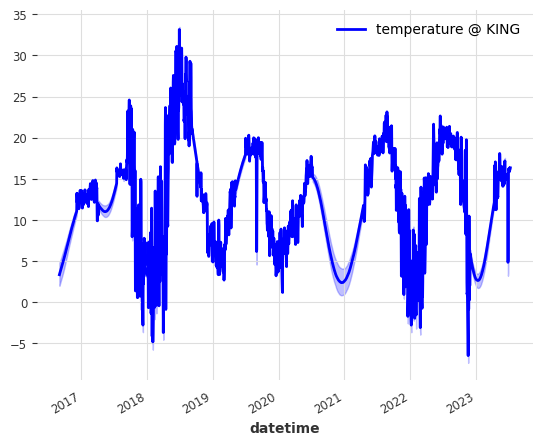

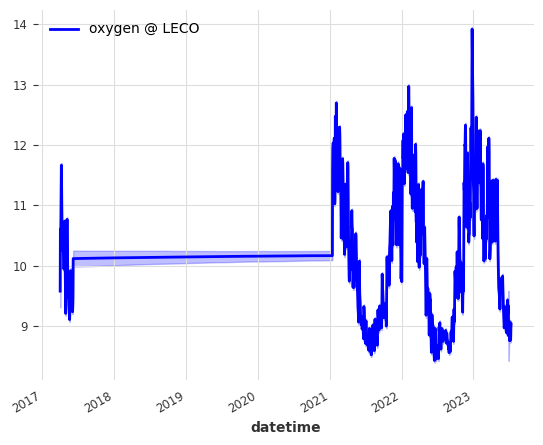

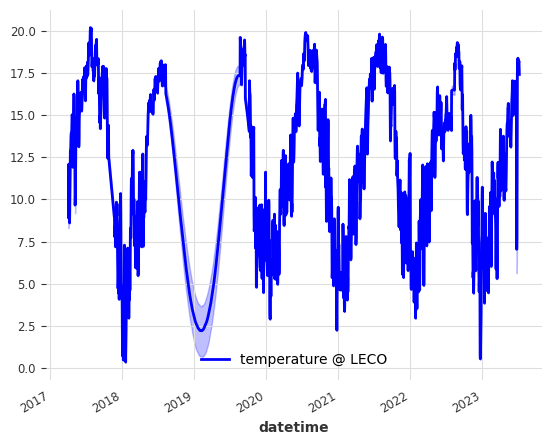

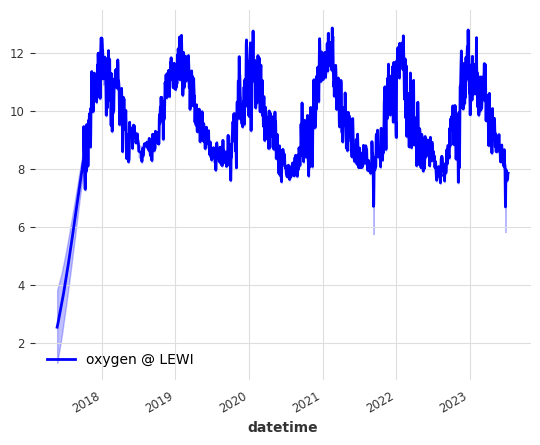

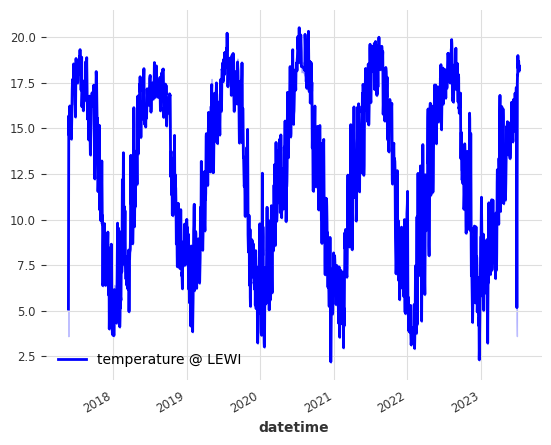

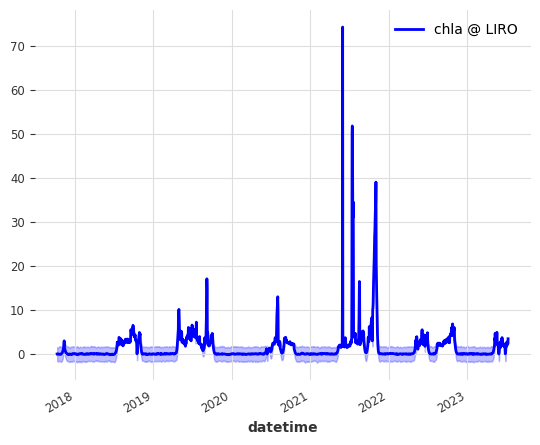

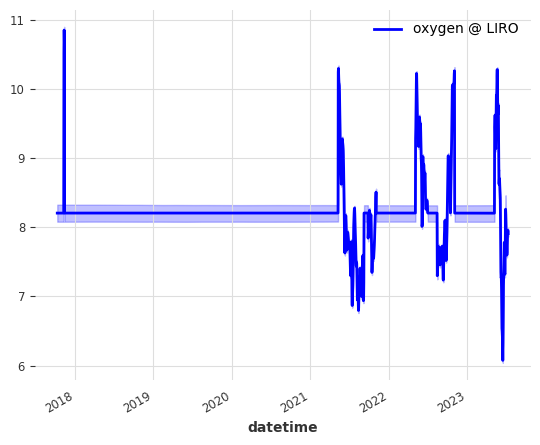

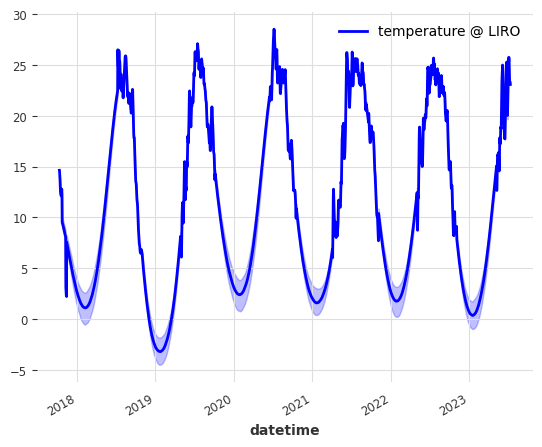

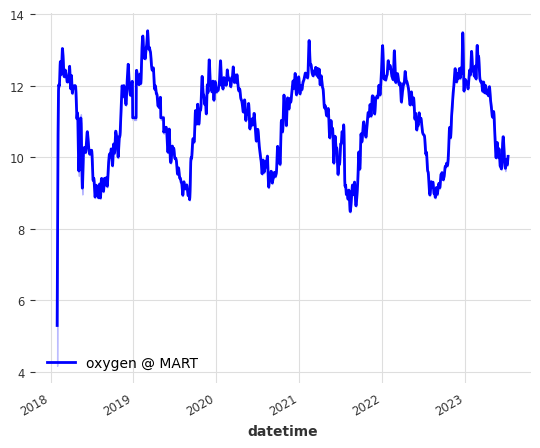

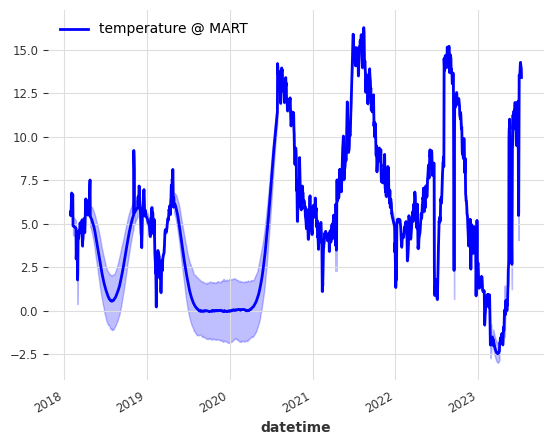

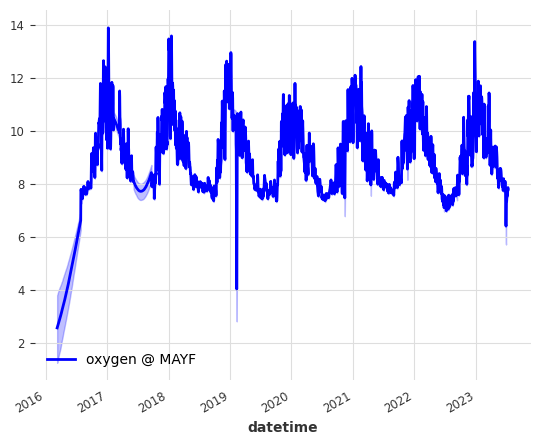

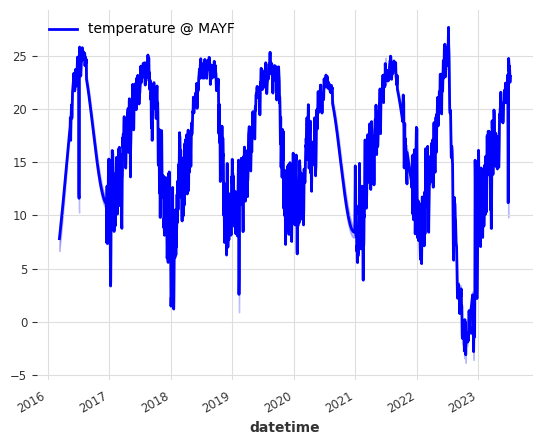

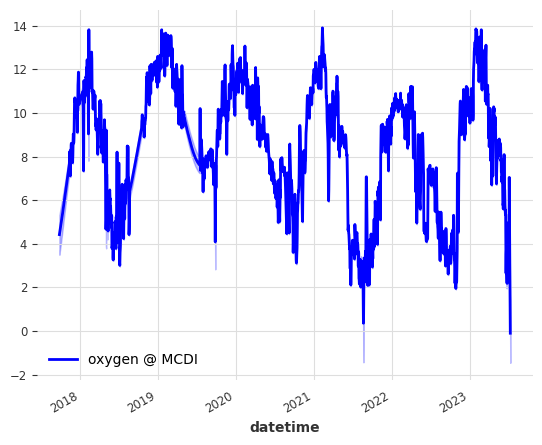

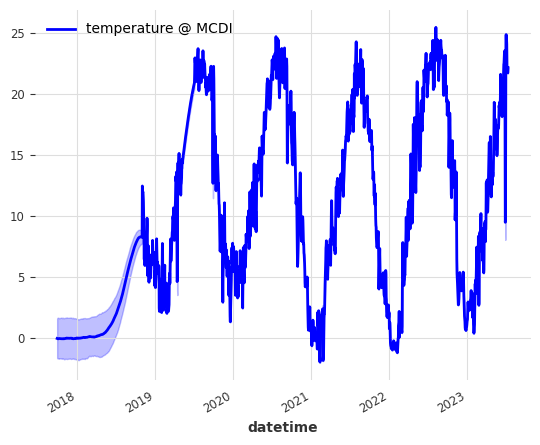

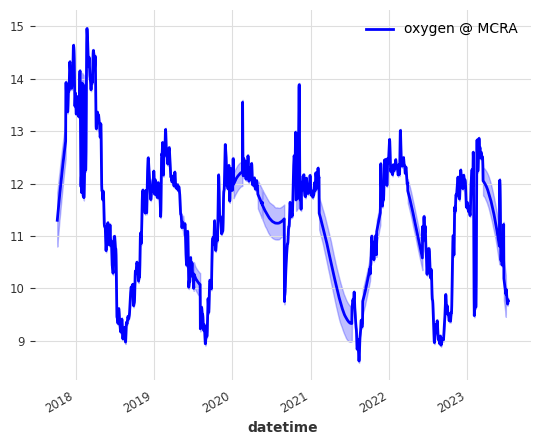

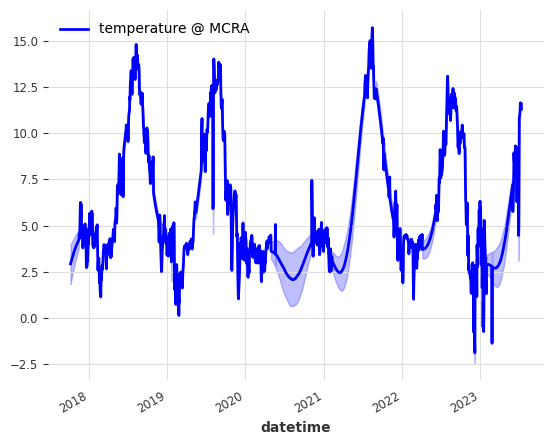

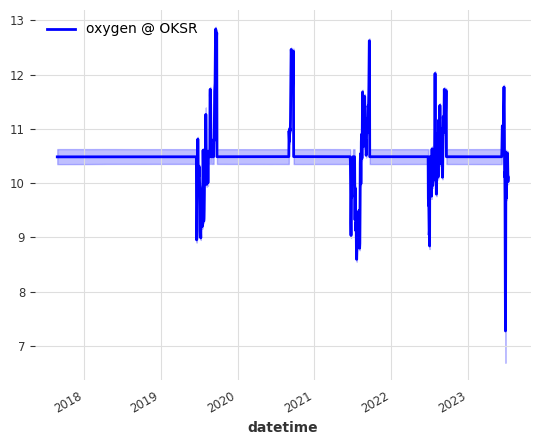

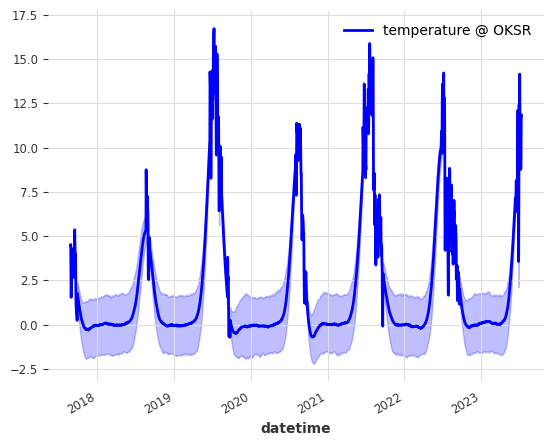

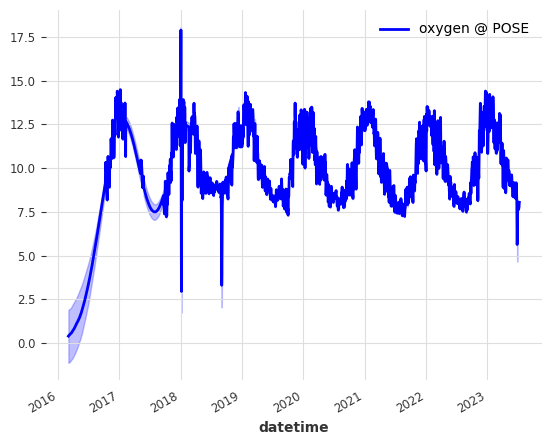

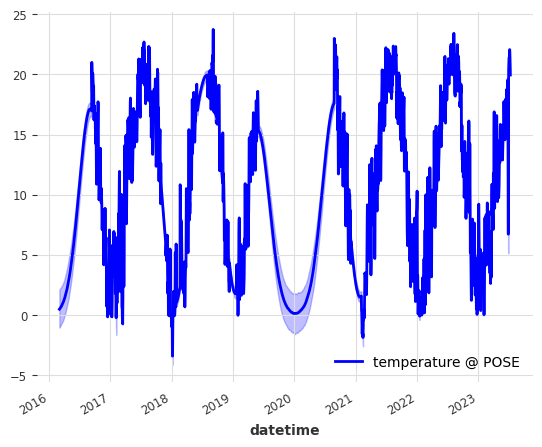

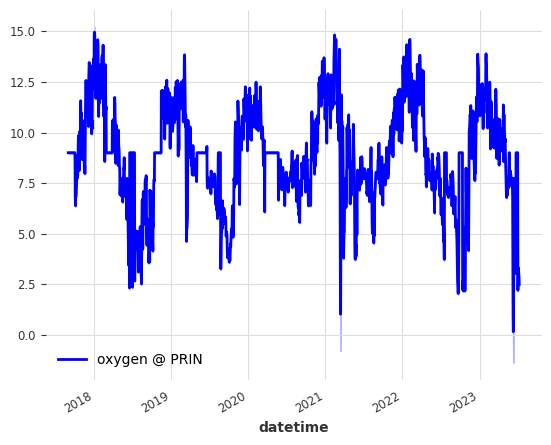

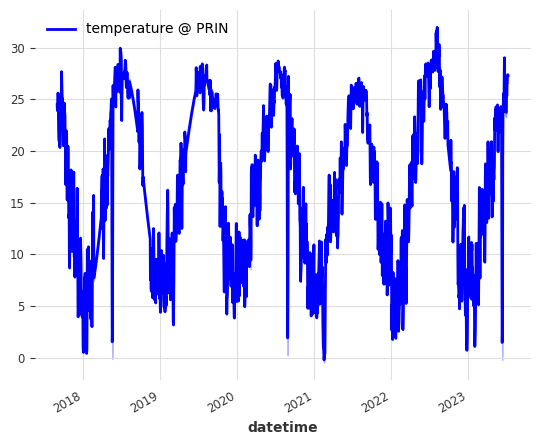

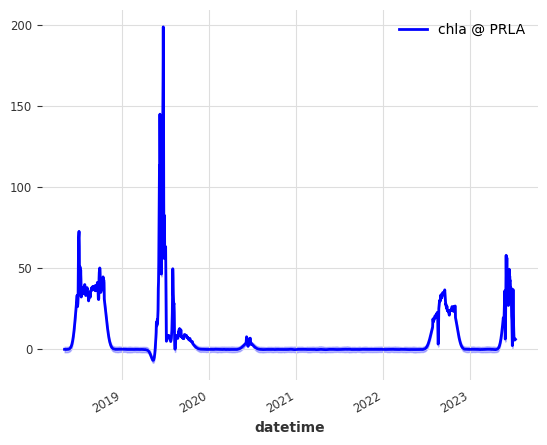

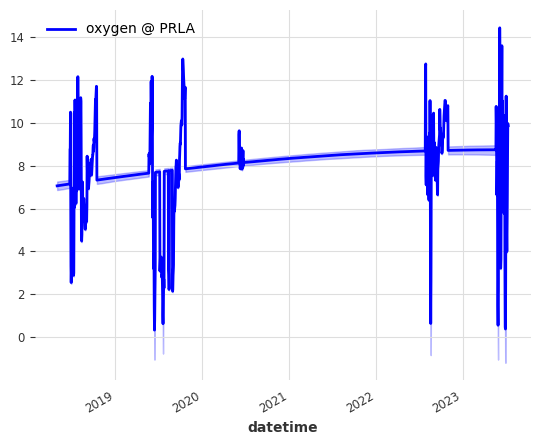

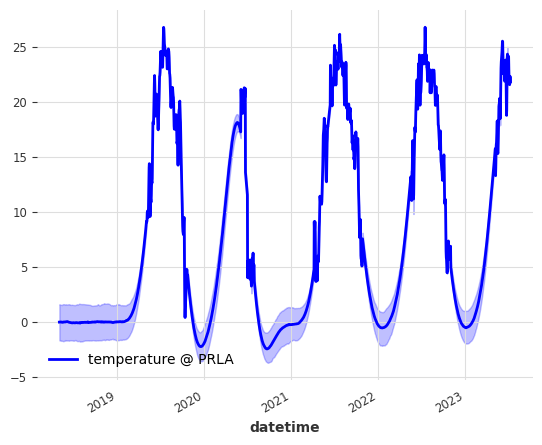

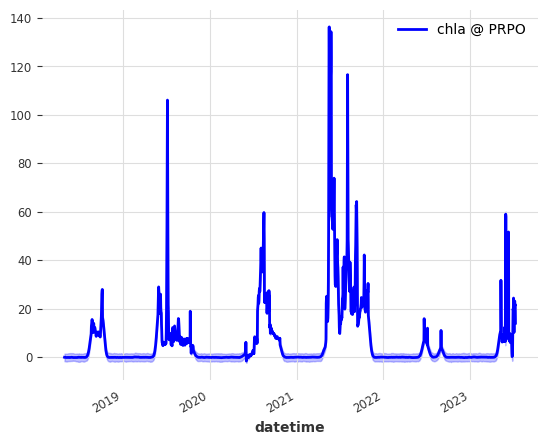

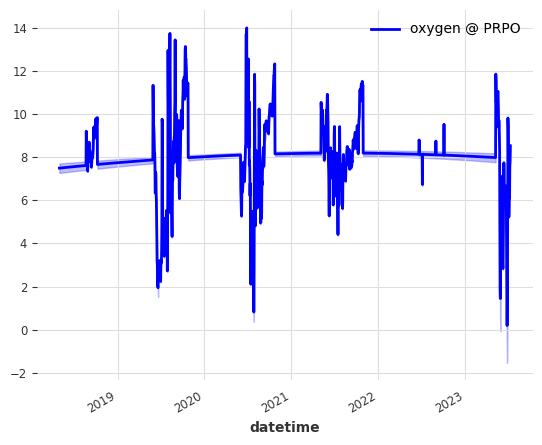

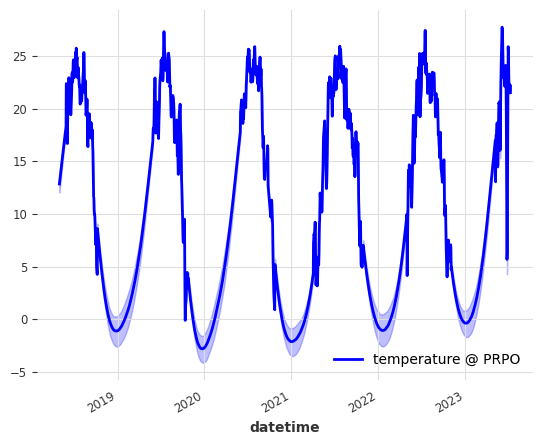

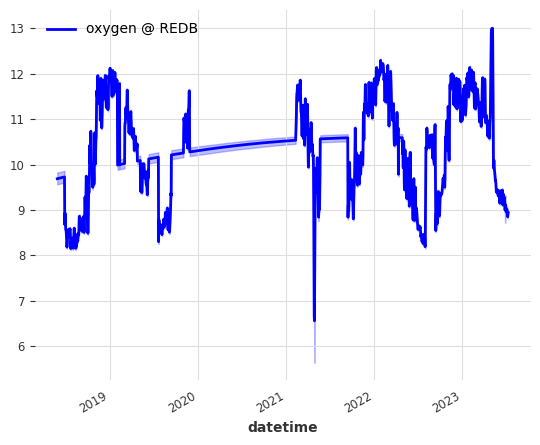

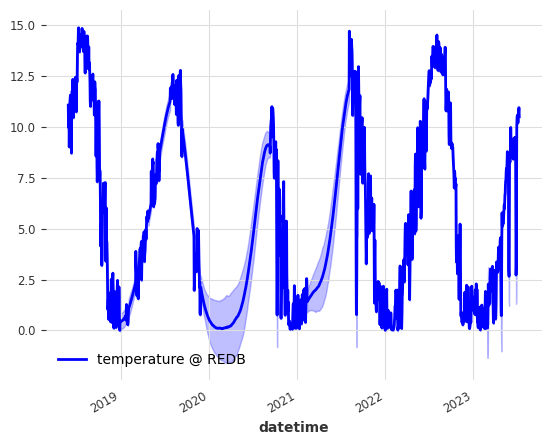

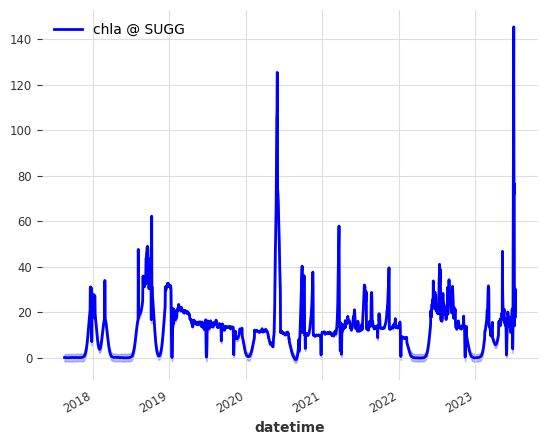

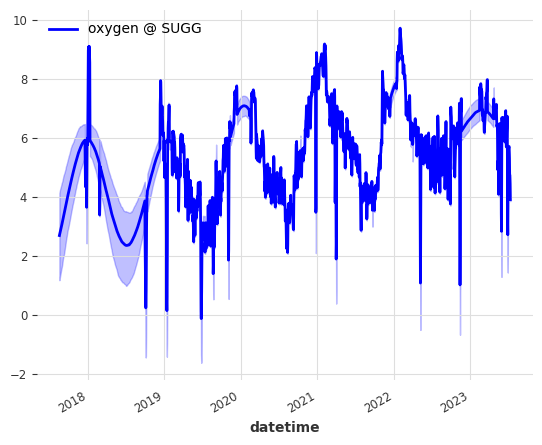

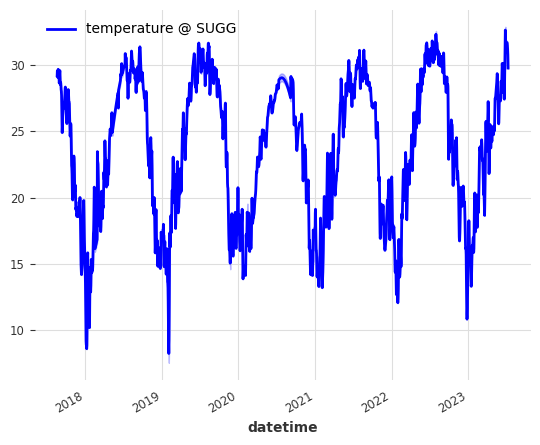

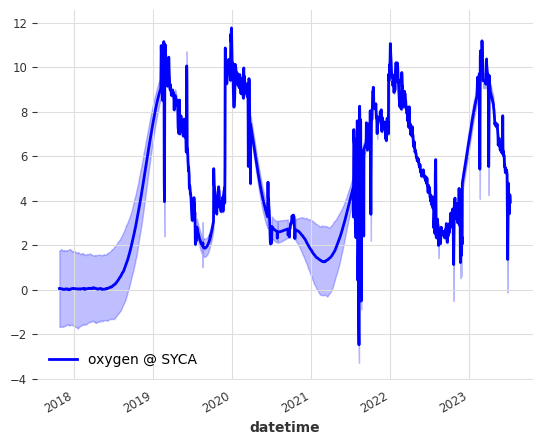

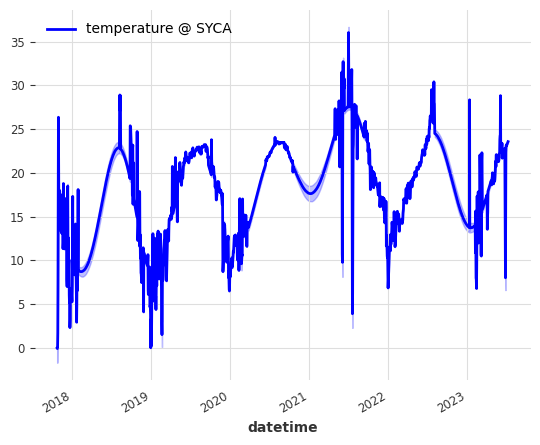

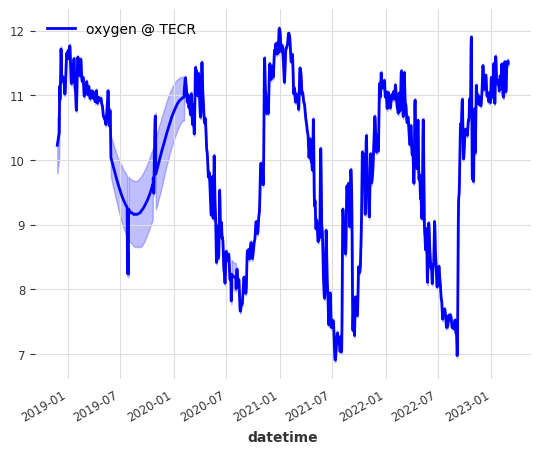

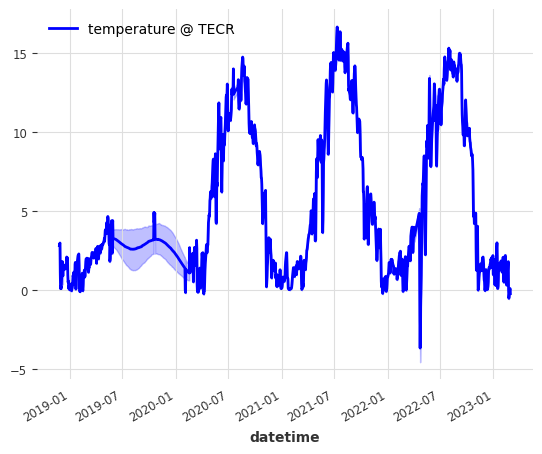

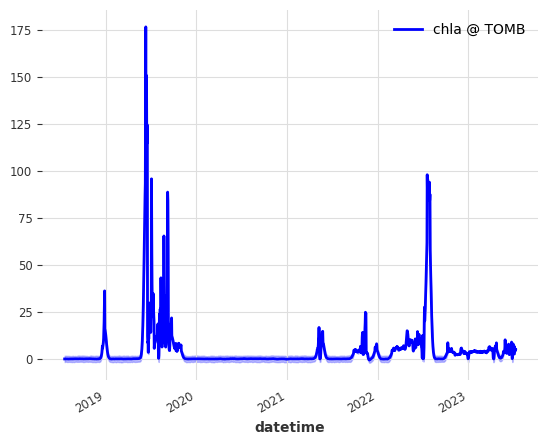

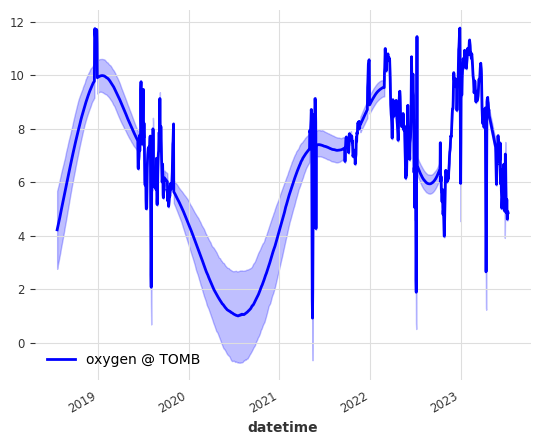

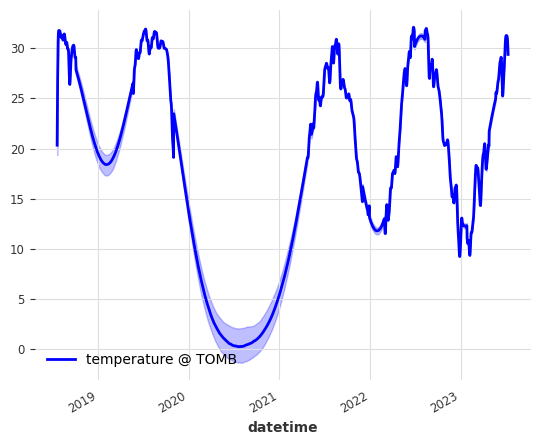

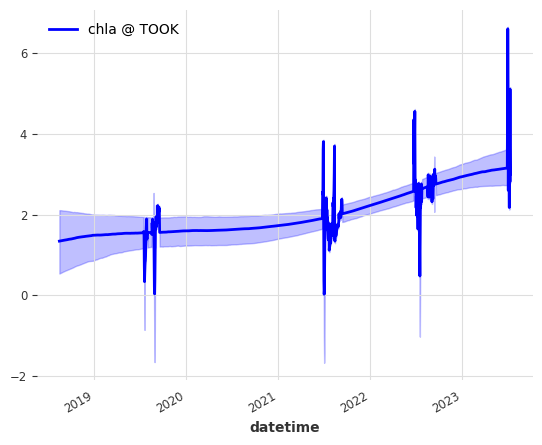

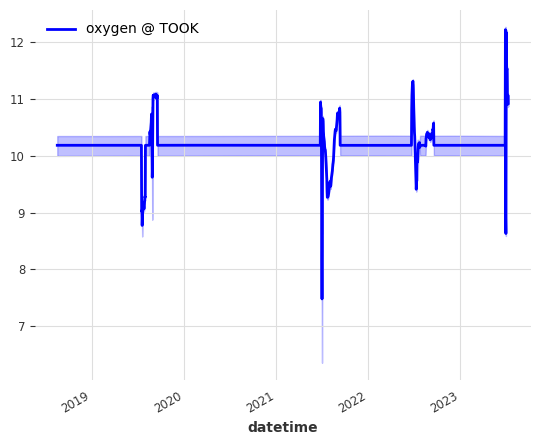

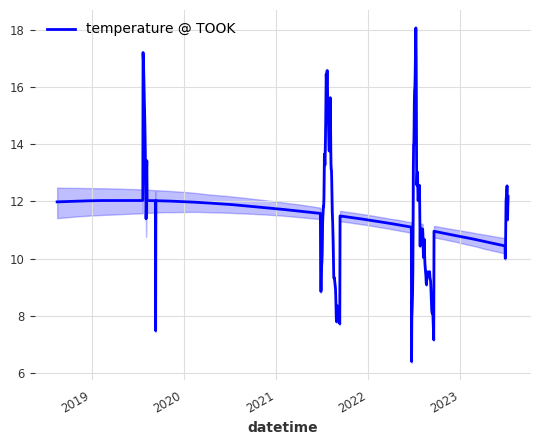

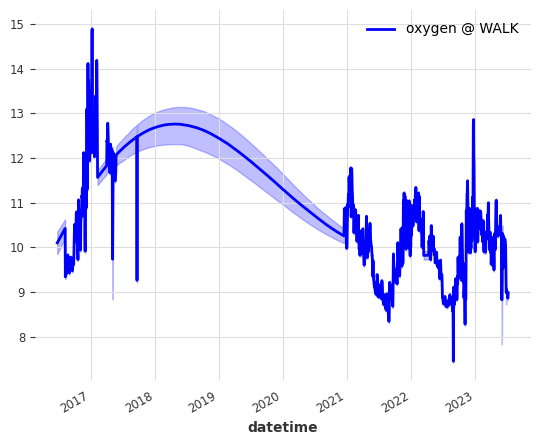

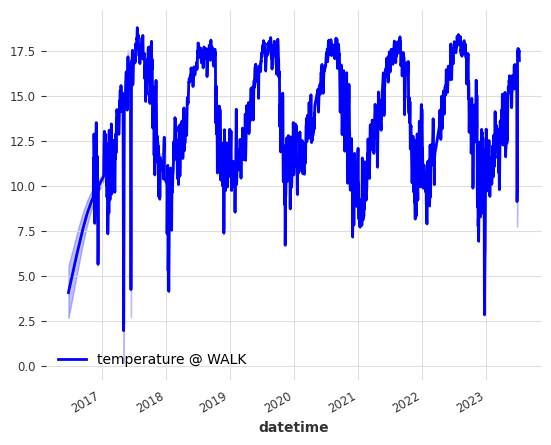

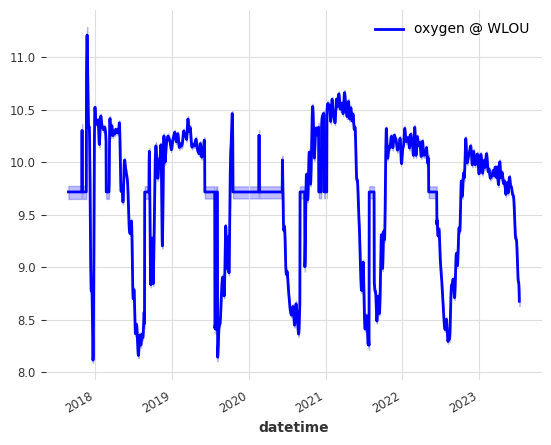

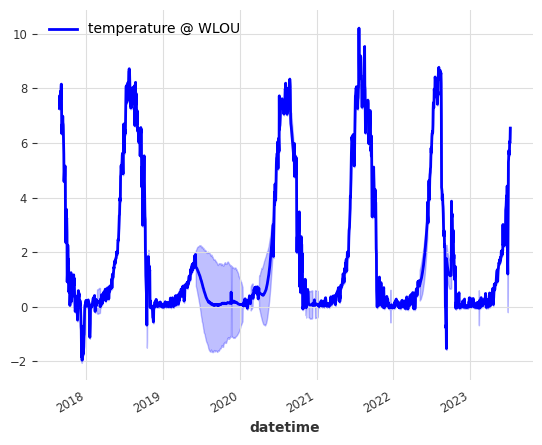

In [158]:
for site in targets["site_id"].unique():
    plot_by_site(data_preprocessor, site)

Need to write function to save and load csv's of the stitched time series.

In [162]:
import os
import warnings
warnings.filterwarnings("ignore")

def save(preprocessor):
    # Check if there's a dir already
    if not os.path.exists("preprocessed_timeseries/"):
        os.makedirs("preprocessed_timeseries/")

    # Saving each TimeSeries
    for site in preprocessor.sites_dict.keys():
        for variable in preprocessor.sites_dict[site]:
            preprocessor.sites_dict[site][variable].pd_dataframe()\
                .to_csv(f"preprocessed_timeseries/{site}_{variable}.csv")

In [163]:
save(data_preprocessor)

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consi

In [176]:
sites_dict = {}


In [178]:
"x" not in sites_dict.keys() or sites_dict["x"] == {}

True

In [189]:
sites_dict["foo"] = [1]

In [190]:
sites_dict["foo"].append(2)
sites_dict

{'foo': [1, 2], 'fum': 2}

In [199]:
def load_series(preprocessor):
    # Need to check what are the possible variables that there could be in null, 
    # and when you load a series need to log which ones aren't added
    variables = {"chla", "oxygen", "temperature", "air_tmp"}
    sites_dict_present = {}
    
    # Need to fill sites_dict and sites_dict_null
    dir_path = "preprocessed_timeseries/"
    files = os.listdir(dir_path)
    for file in files:
        if file.endswith(".csv"):
            # Reading in file name
            site, variable = file.replace(".csv", "").split("_")
            file_path = os.path.join(dir_path, file)
            df = pd.read_csv(file_path)

            # To make a time series, need to isolate time index and values
            times = pd.to_datetime(df["datetime"])
            times = pd.DatetimeIndex(times)
            values = df.loc[:, df.columns!="datetime"].to_numpy()\
                    .reshape((-1, 1, 500))
            time_series = TimeSeries.from_times_and_values(times, 
                                                           values, 
                                          fill_missing_dates=True, 
                                                         freq="D")

            # Initialize the site dict entry if one doesn't exist already
            if site not in preprocessor.sites_dict.keys():
                preprocessor.sites_dict[site] = {}
            preprocessor.sites_dict[site][variable] = time_series

            # Need to keep track of the variables over different csv's
            # for each site
            if site not in sites_dict_present.keys():
                sites_dict_present[site] = [variable]
            else:
                sites_dict_present[site].append(variable)


    for site in sites_dict_present.keys():
        variables_present = set(sites_dict_present[site])
        absent_variables = list(variables - variables_present)
        preprocessor.sites_dict_null[site] = absent_variables
        

In [200]:
test_load_preprocessor = TimeSeriesPreprocessor()
load_series(test_load_preprocessor)

In [203]:
test_load_preprocessor.sites_dict_null

{'SYCA': ['air_tmp', 'chla'],
 'GUIL': ['air_tmp', 'chla'],
 'LEWI': ['air_tmp', 'chla'],
 'ARIK': ['air_tmp', 'chla'],
 'OKSR': ['air_tmp', 'chla'],
 'CARI': ['air_tmp', 'chla'],
 'CRAM': ['air_tmp'],
 'KING': ['air_tmp', 'chla'],
 'HOPB': ['air_tmp', 'chla'],
 'MAYF': ['air_tmp', 'chla'],
 'WALK': ['air_tmp', 'chla'],
 'TOMB': ['air_tmp'],
 'BLWA': ['air_tmp'],
 'MCDI': ['air_tmp', 'chla'],
 'COMO': ['air_tmp', 'chla'],
 'POSE': ['air_tmp', 'chla'],
 'TOOK': ['air_tmp'],
 'BLUE': ['air_tmp', 'chla'],
 'MCRA': ['air_tmp', 'chla'],
 'PRLA': ['air_tmp'],
 'TECR': ['air_tmp', 'chla'],
 'REDB': ['air_tmp', 'chla'],
 'BIGC': ['air_tmp', 'chla'],
 'PRIN': ['air_tmp', 'chla'],
 'CUPE': ['air_tmp', 'chla'],
 'MART': ['air_tmp', 'chla'],
 'BARC': ['air_tmp'],
 'LECO': ['air_tmp', 'chla'],
 'FLNT': ['air_tmp'],
 'SUGG': ['air_tmp'],
 'PRPO': ['air_tmp'],
 'WLOU': ['air_tmp', 'chla'],
 'BLDE': ['air_tmp', 'chla'],
 'LIRO': ['air_tmp']}

Ok, now I am going to work on building a class that allows one to do all the data preprocessing seperately and then saves the processed series so we don't have to do this repeatedly.

In [142]:
block_rnn_forecaster = BaseForecaster(model="BlockRNN",
                                      target_variable_column_name="oxygen",
                                      data_preprocessor=test_preprocessor,
                                      datetime_column_name="datetime",
                                      covariates_names=["air_tmp", "chla", "temperature"],
                                      output_csv_name="trash.csv",
                                      validation_split_date="2023-02-26",
                                      model_hyperparameters={'input_chunk_length': 180, 
                                                             'hidden_dim': 64, 
                                                             'model': 'GRU', 
                                                             'n_rnn_layers': 3},
                                     forecast_horizon=30,
                                     site_id="BARC")

In [143]:
block_rnn_forecaster.make_forecasts()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


{'input_chunk_length': 180, 'hidden_dim': 64, 'model': 'GRU', 'n_rnn_layers': 3}


`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


Testing BlockRNN

In [67]:
block_rnn_forecaster = BaseForecaster(model="BlockRNN",
                                      input_csv_name="targets.csv.gz",
                                      target_variable_column_name="oxygen",
                                      datetime_column_name="datetime",
                                      covariates_names=["air_tmp", "chla", "temperature"],
                                      output_csv_name="trash.csv",
                                      validation_split_date="2023-02-26",
                                      model_hyperparameters={'input_chunk_length': 180, 
                                                             'hidden_dim': 64, 
                                                             'model': 'GRU', 
                                                             'n_rnn_layers': 3},
                                     forecast_horizon=30,
                                     site_id="ARIK")

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consi

Failed to make a GP fit on air_tmp
Failed to make a GP fit on chla


In [68]:
block_rnn_forecaster.make_forecasts()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


{'input_chunk_length': 180, 'hidden_dim': 64, 'model': 'GRU', 'n_rnn_layers': 3}


`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


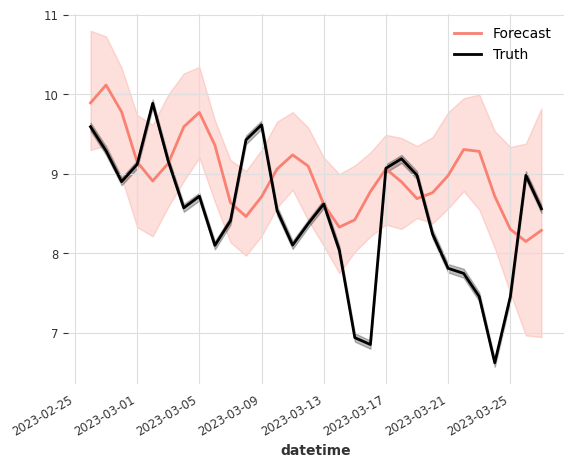

In [69]:
df = pd.read_csv("trash.csv")
times = pd.to_datetime(df["datetime"])
times = pd.DatetimeIndex(times)
values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((block_rnn_forecaster.forecast_horizon, 1, -1))
direct_predictions_ts = TimeSeries.from_times_and_values(times, 
                                                         values, 
                                                         fill_missing_dates=True, freq="D")

plt.clf()
direct_predictions_ts.plot(color="salmon", label="Forecast")
block_rnn_forecaster.validation_set[:block_rnn_forecaster.forecast_horizon].plot(color="black", label="Truth")
plt.show()

In [70]:
block_rnn_forecaster.get_historicals_and_residuals()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), us

Testing NBEATS

In [44]:
nbeats_forecaster = BaseForecaster(model="NBEATS",
                                      input_csv_name="targets.csv.gz",
                                      target_variable_column_name="oxygen",
                                      datetime_column_name="datetime",
                                      covariates_names=["air_tmp", "chla", "temperature"],
                                      output_csv_name="trash_NBEATS.csv",
                                      validation_split_date="2023-02-26",
                                      model_hyperparameters={'input_chunk_length': 180,
                                                            },
                                     forecast_horizon=30,
                                     site_id="ARIK")

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consi

Failed to make a GP fit on air_tmp
Failed to make a GP fit on chla


In [45]:
nbeats_forecaster.make_forecasts()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


{'input_chunk_length': 180}


`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


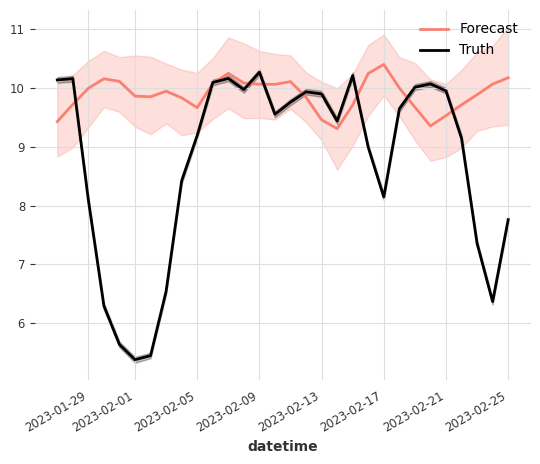

In [46]:
df = pd.read_csv("trash_NBEATS.csv")
times = pd.to_datetime(df["datetime"])
times = pd.DatetimeIndex(times)
values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((block_rnn_forecaster.forecast_horizon, 1, -1))
direct_predictions_ts = TimeSeries.from_times_and_values(times, 
                                                         values, 
                                                         fill_missing_dates=True, freq="D")

plt.clf()
direct_predictions_ts.plot(color="salmon", label="Forecast")
block_rnn_forecaster.validation_set[:block_rnn_forecaster.forecast_horizon].plot(color="black", label="Truth")
plt.show()

And N-Linear

In [47]:
nlinear_forecaster = BaseForecaster(model="NLinear",
                                      input_csv_name="targets.csv.gz",
                                      target_variable_column_name="oxygen",
                                      datetime_column_name="datetime",
                                      covariates_names=["air_tmp", "chla", "temperature"],
                                      output_csv_name="trash_NLinear.csv",
                                      validation_split_date="2023-02-26",
                                      model_hyperparameters={'input_chunk_length': 180,
                                                            },
                                     forecast_horizon=30,
                                     site_id="ARIK")

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consi

Failed to make a GP fit on air_tmp
Failed to make a GP fit on chla


In [48]:
nlinear_forecaster.make_forecasts()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


{'input_chunk_length': 180}


`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


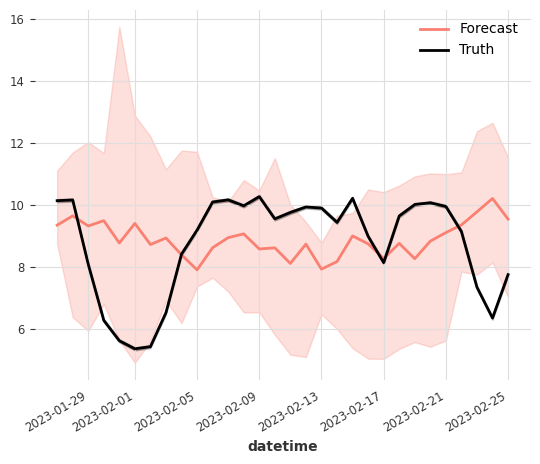

In [49]:
df = pd.read_csv("trash_NLinear.csv")
times = pd.to_datetime(df["datetime"])
times = pd.DatetimeIndex(times)
values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((block_rnn_forecaster.forecast_horizon, 1, -1))
direct_predictions_ts = TimeSeries.from_times_and_values(times, 
                                                         values, 
                                                         fill_missing_dates=True, freq="D")

plt.clf()
direct_predictions_ts.plot(color="salmon", label="Forecast")
block_rnn_forecaster.validation_set[:block_rnn_forecaster.forecast_horizon].plot(color="black", label="Truth")
plt.show()

In [51]:
def read_csv(csv_filename):
    df = pd.read_csv(csv_filename)
    times = pd.to_datetime(df["datetime"])
    times = pd.DatetimeIndex(times)
    values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((block_rnn_forecaster.forecast_horizon, 1, -1))
    direct_predictions_ts = TimeSeries.from_times_and_values(times, 
                                                             values, 
                                                             fill_missing_dates=True, freq="D")

    return direct_predictions_ts

In [52]:
block_rnn_preds = read_csv("trash.csv")
NBEATS_preds = read_csv("trash_NBEATS.csv")
NLinear_preds = read_csv("trash_NLinear.csv")

for preds in [block_rnn_preds, NBEATS_preds, NLinear_preds]:
    smapes = smape(block_rnn_forecaster.validation_set[:block_rnn_forecaster.forecast_horizon],
              preds,
              n_jobs=-1, 
              verbose=False)
    print(np.mean(smapes))

15.486643966411945
16.796052857085364
18.593433992310956


Now will try residual correction to see if that leads to better forecasts

In [53]:
for forecaster in [block_rnn_forecaster, nlinear_forecaster, nbeats_forecaster]:
    forecaster.get_historicals_and_residuals()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
GPU available: True (cuda), us

In [54]:
# Lets add residual samples to median forecast! then check the smape of that

In [58]:
residual_forecasters = {}
forecasters = {"block": block_rnn_forecaster, "nlinear": nlinear_forecaster, "nbeats": nbeats_forecaster}
for name, object in forecasters.items():
    residual_forecaster = ResidualForecasterDarts(
        historical_forecasts=object.historical_forecasts,
        historical_ground_truth=object.historical_ground_truth,
        covariates=object.covariates,
        validation_split_date="2022-12-28",
        output_csv_name = f"{name}_residual_forecaster.csv",
        forecast_horizon=7
    )
    residual_forecaster.make_residual_forecasts()
    residual_forecasters[name] = residual_forecaster
    

{'input_chunk_length': 180}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


{'input_chunk_length': 180}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


{'input_chunk_length': 180}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


In [91]:
start_date = pd.Timestamp(year=2022, month=12, day=28)
end_date = pd.Timestamp(year=2023, month=1, day=3)
historical_forecast = block_rnn_forecaster.historical_forecasts.slice(start_date, end_date)
historical_ground_truth = block_rnn_forecaster.historical_ground_truth.slice(start_date, end_date)

In [78]:
direct_csv_names = {"block": "trash.csv", "nlinear": "trash_NLinear.csv", "nbeats": "trash_NBEATS.csv"}
direct_predictions = {}

for name, csv in direct_csv_names.items():
    df = pd.read_csv(f"{csv}")
    times = pd.to_datetime(df["datetime"])
    times = pd.DatetimeIndex(times)
    values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((forecasters[name].forecast_horizon, 1, -1))
    direct_predictions_ts = TimeSeries.from_times_and_values(times, 
                                                             values, 
                                                             fill_missing_dates=True, freq="D")
    direct_predictions[name] = direct_predictions_ts

In [79]:
def stack_ts(timeseries, n_samples=500):
    output = timeseries.copy()
    for i in range(n_samples-1):
        output = output.concatenate(timeseries, axis=2)
    return output

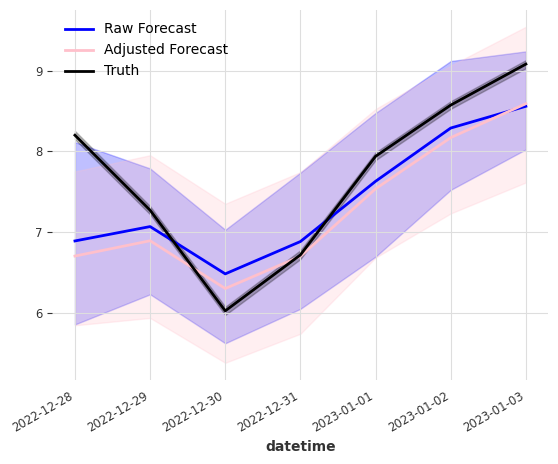

In [92]:
df = pd.read_csv("block_residual_forecaster.csv")
times = pd.to_datetime(df["datetime"])
times = pd.DatetimeIndex(times)
values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((residual_forecasters["block"].forecast_horizon, 1, -1))
residuals = TimeSeries.from_times_and_values(times, 
                                             values, 
                                             fill_missing_dates=True, freq="D")
medians = stack_ts(historical_forecast.quantile_timeseries(0.5))
plt.clf()
historical_forecast.plot(color="blue", label="Raw Forecast")
(medians+residuals).plot(color="pink", label="Adjusted Forecast")
historical_ground_truth.plot(color="black", label="Truth")
plt.show()